In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py

import math
from colour import Color

from scipy import stats as scipystats

In [2]:
path = os.getcwd()

In [3]:
# Return the total number of parameters
# 785 corresponds to the input size plus a bias unit (28*28+1)
def tot_parameters(n_units1, n_units2):
    return 785*n_units1 + (n_units1+1)*n_units2 + (n_units2+1)*10

In [4]:
# Here a nice looking colormap is created
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
# Get the trained information
stats = pd.read_csv("{0}/Outputs/Stats.txt".format(os.path.split(path)[0]), header=None)
stats.columns = ['n_units1', 'n_units2', 'learning_rate', 'seed', 'untrained_accuracy', 'trained_accuracy', 'best_val_acc', 'best_epoch']

In [6]:
# Compute the trained accuracy (the one based on 5000 test set points after training)
stats['trained_accuracy_mean'] = stats.groupby(['n_units1','n_units2','learning_rate'], as_index=False)['trained_accuracy'].transform('mean')
stats['trained_accuracy_std']  = stats.groupby(['n_units1','n_units2','learning_rate'], as_index=False)['trained_accuracy'].transform('std')
# Compute the untrained accuracy (the one based on 200 train set points before training)
stats['untrained_accuracy_mean'] = stats.groupby(['n_units1', 'n_units2'], as_index=False)['untrained_accuracy'].transform('mean')
stats['untrained_accuracy_std']  = stats.groupby(['n_units1', 'n_units2'], as_index=False)['untrained_accuracy'].transform('std')
# Figuring the best mean learning rate over 100 initializations for every architecture
stats['best_mean_learning_rate'] = stats.sort_values(by=['n_units1','n_units2', 'trained_accuracy_mean'], ascending=False).groupby(['n_units1', 'n_units2'])['learning_rate'].transform(lambda x: [x.head(1)]*len(x))
# Calculate the log of the total number of parameters (for plots colors)
stats['n_parameters'] = np.log10(tot_parameters(stats['n_units1'], stats['n_units2']))

In [7]:
stats_short = stats.drop_duplicates(subset=['n_units1', 'n_units2', 'learning_rate']).reset_index(drop=True)
stats_short = stats_short.loc[stats_short['learning_rate']==stats_short['best_mean_learning_rate']].reset_index(drop=True)

In [8]:
# Preparing the colormap
cmap = plt.get_cmap('inferno_r')
new_cmap = truncate_colormap(cmap, 0.12, 0.63)

min_par = np.log10(tot_parameters(8, 8))
max_par = np.log10(tot_parameters(2048, 2048))
min_units = np.log10(8)
max_units = np.log10(2048)

matplotlib.rcParams.update({'font.size': 18})

Mean untrained accuracy $\mu_U$ plot against mean trained accuracy $\mu_T$ , both computed over $N_{init}$ = 100 initialisations. One point stands for one architecture. The colours represent the logarithm of the number of parameters for a given architecture. 

In the article this figure is indexed as Figure 1a.

/home/ekaterina/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


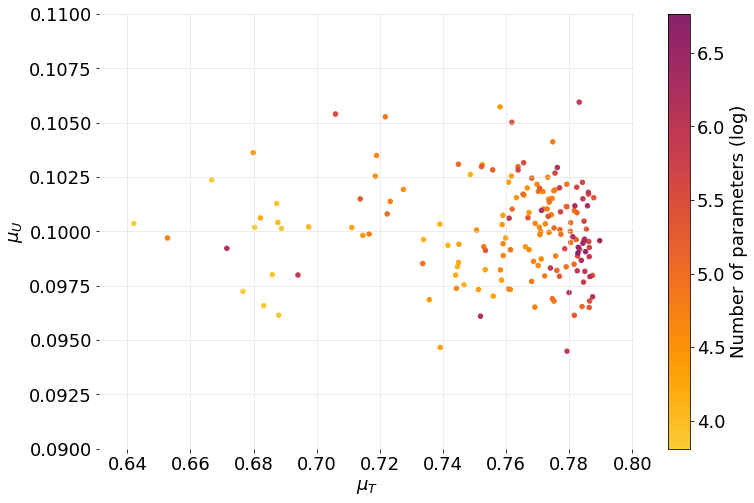

In [9]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\mu_{T}$', fontsize = 18)
plt.ylabel('$\mu_{U}$', fontsize = 18)
ax = fig.add_subplot(111)

psm = ax.scatter(stats_short['trained_accuracy_mean'],
            stats_short['untrained_accuracy_mean'], 
            s=20,
            c=stats_short['n_parameters'],
            cmap=new_cmap,
            vmin=min_par,
            vmax=max_par
            )
clb = fig.colorbar(psm, ax=ax)
clb.set_label('Number of parameters (log)', fontsize = 18)
ax.set_ylim(0.09, 0.11)

plt.savefig("{0}/Outputs/MuT_MuU.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

Standard deviation of untrained accuracy $\sigma_U$ plot against mean trained accuracy $\mu_T$ , both computed over $N_{init}$ = 100 initialisations. One point stands for one architecture. The colours represent the logarithm of the number of parameters for a given architecture. 

In the article this figure is indexed as Figure 1b.

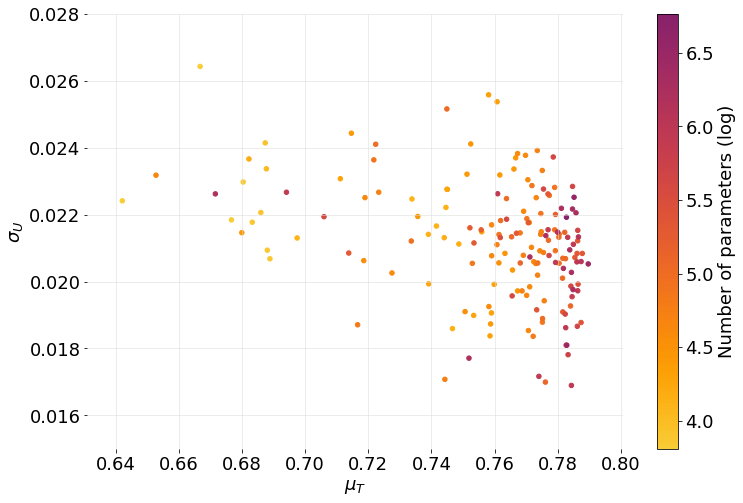

In [10]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\mu_{T}$', fontsize = 18)
plt.ylabel('$\sigma_{U}$', fontsize = 18)
ax = fig.add_subplot(111)

psm = ax.scatter(stats_short['trained_accuracy_mean'],
            stats_short['untrained_accuracy_std'], 
            s=20,
            c=stats_short['n_parameters'],
            cmap=new_cmap,
            vmin=min_par,
            vmax=max_par
            )
clb = fig.colorbar(psm, ax=ax)
clb.set_label('Number of parameters (log)', fontsize = 18)
ax.set_ylim(0.015, 0.028)

plt.savefig("{0}/Outputs/MuT_SigmaU.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

Standard deviation of untrained accuracy $\sigma_U$ plot against mean untrained accuracy $\mu_U$, both computed over $N_{init}$ = 100 initialisations. One point stands for one architecture. The colours represent the logarithm of the number of parameters for a given architecture.

In the article this figure is indexed as Figure 2a.

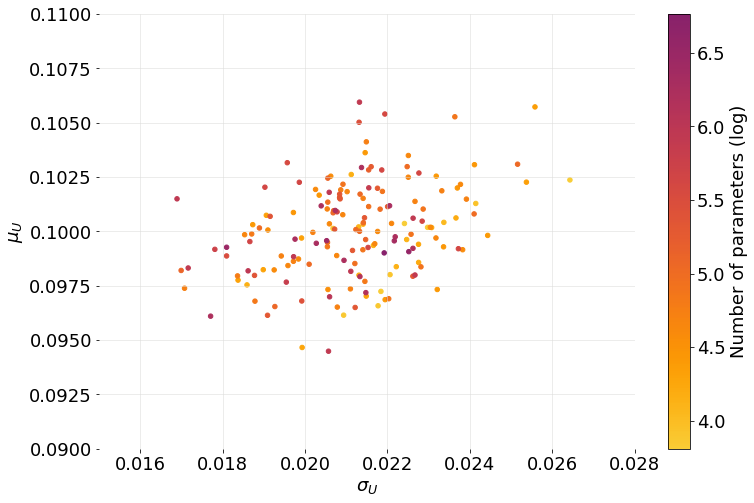

In [12]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\sigma_{U}$', fontsize = 18)
plt.ylabel('$\mu_{U}$', fontsize = 18)

ax = fig.add_subplot(111)

psm = ax.scatter(stats_short['untrained_accuracy_std'],
                 stats_short['untrained_accuracy_mean'], 
                 s=20,
                 c=stats_short['n_parameters'],
                 cmap=new_cmap,
                 vmin=min_par,
                 vmax=max_par
                )
clb = fig.colorbar(psm, ax=ax)
clb.set_label('Number of parameters (log)', fontsize = 18)
ax.set_xlim(0.015, 0.028)
ax.set_ylim(0.09, 0.11)



plt.savefig("{0}/Outputs/MuU_SigmaU.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

Relative standard deviation of untrained accuracy $\sigma_r$ plot against mean untrained accuracy $\mu_U$, both computed over $N_{init}$ = 100 initialisations. One point stands for one architecture. The colours represent the logarithm of the number of parameters for a given architecture.

In the article this figure is indexed as Figure 2b.

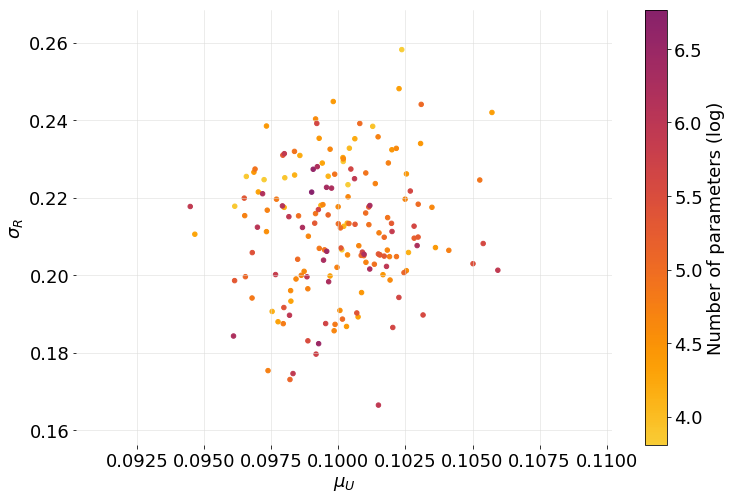

In [13]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\mu_{U}$', fontsize = 18)
plt.ylabel('$\sigma_{R}$', fontsize = 18)
ax = fig.add_subplot(111)

psm = ax.scatter(stats_short['untrained_accuracy_mean'],
                 stats_short['untrained_accuracy_std']/stats_short['untrained_accuracy_mean'],
                 s=20,
                 c=stats_short['n_parameters'],
                 cmap=new_cmap,
                 vmin=min_par,
                 vmax=max_par
                )
clb = fig.colorbar(psm, ax=ax)
clb.set_label('Number of parameters (log)',fontsize = 18)
# ax.set_ylim(0.09, 0.11)
# ax.set_xlim(0.015, 0.028)


plt.savefig("{0}/Outputs/MuU_SigmaR.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

#### The principal plot of the MNIST part

Relative standard deviation of the untrained accuracy $\sigma_{r}$ plot against mean trained accuracy $\mu_{T}$, both computed over $N_{init}=100$ initialisations. One point stands for one architecture. The colours represent the number of parameters contained within an architecture.

In the article this figure is indexed as Figure 3.

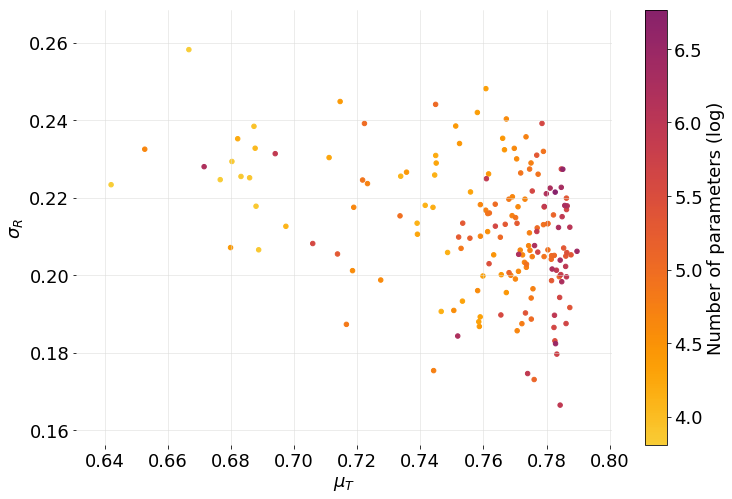

In [10]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\mu_{T}$', fontsize = 18)
plt.ylabel('$\sigma_{R}$', fontsize = 18)
ax = fig.add_subplot(111)

psm = ax.scatter(stats_short['trained_accuracy_mean'],
            stats_short['untrained_accuracy_std']/stats_short['untrained_accuracy_mean'],
            s=20,
            c=stats_short['n_parameters'],
            cmap=new_cmap,
            vmin=min_par,
            vmax=max_par
            )
clb = fig.colorbar(psm, ax=ax)
clb.set_label('Number of parameters (log)', fontsize = 18)
plt.savefig("{0}/Outputs/MuT_SigmaR.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

The number of parameters plot against the scoring metric $\sigma_{r}$, or the relative standard deviation of the untrained performance, computed over $N_{init}=100$ initialisations. One point stands for one architecture. The colours represent the number of units in the first layer.

In the article this figure is indexed as Figure 4a.

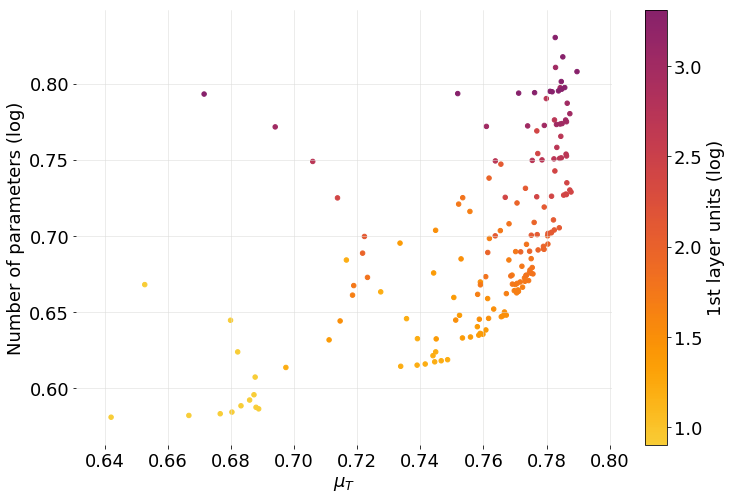

In [11]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\mu_{T}$', fontsize = 18)
plt.ylabel('Number of parameters (log)', fontsize = 18)
ax = fig.add_subplot(111)

psm = ax.scatter(stats_short['trained_accuracy_mean'],
            np.log10(stats_short['n_parameters']),
            s=20,
            c=np.log10(stats_short['n_units1']),
            cmap=new_cmap,
            vmin=min_units,
            vmax=max_units
            )
clb = fig.colorbar(psm, ax=ax)
clb.set_label('1st layer units (log)', fontsize = 18)
plt.savefig("{0}/Outputs/MuT_nUnits1.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

The number of parameters plot against the scoring metric $\sigma_{r}$, or the relative standard deviation of the untrained performance, computed over $N_{init}=100$ initialisations. One point stands for one architecture. The colours represent the number of units in the second layer.

In the article this figure is indexed as Figure 4b.

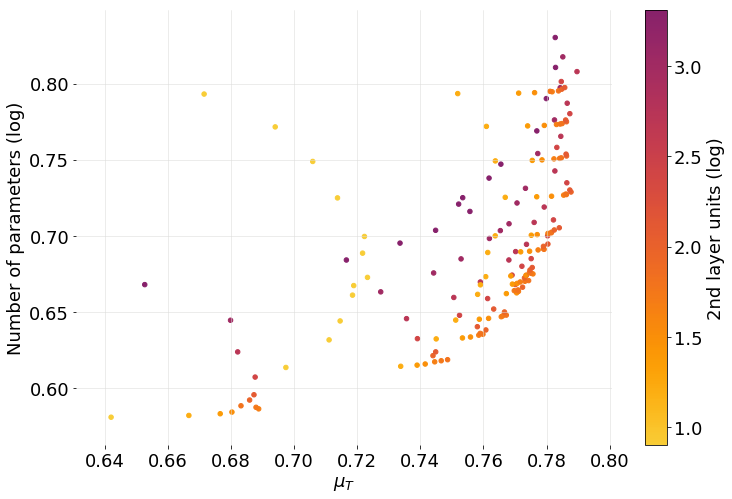

In [189]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\mu_{T}$', fontsize = 18)
plt.ylabel('Number of parameters (log)', fontsize = 18)
ax = fig.add_subplot(111)

psm = ax.scatter(stats_short['trained_accuracy_mean'],
            np.log10(stats_short['n_parameters']),
            s=20,
            c=np.log10(stats_short['n_units2']),
            cmap=new_cmap,
            vmin=min_units,
            vmax=max_units
            )
clb = fig.colorbar(psm, ax=ax)
clb.set_label('2nd layer units (log)', fontsize = 18)
plt.savefig("{0}/Outputs/MuT_nUnits2.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

The number of parameters plot against the scoring metric $\sigma_{r}$, or the relative standard deviation of the untrained performance, computed over $N_{init}=100$ initialisations. One point stands for one architecture. The colours represent the number of units in the first layer.

In the article this figure is indexed as Figure 5a.

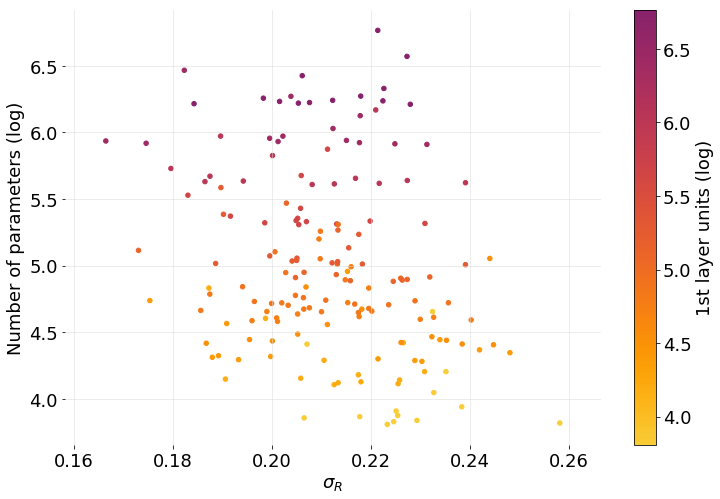

In [180]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\sigma_{R}$', fontsize = 18)
plt.ylabel('Number of parameters (log)', fontsize = 18)
ax = fig.add_subplot(111)
ax.scatter(stats_short['untrained_accuracy_std']/stats_short['untrained_accuracy_mean'],
           stats_short['n_parameters'],
           s=20,
           c=np.log10(stats_short['n_units1']),
           cmap=new_cmap,
           vmin=min_units,
           vmax=max_units
           )

clb = fig.colorbar(psm, ax=ax)
clb.set_label('1st layer units (log)', fontsize = 18)
plt.savefig("{0}/Outputs/Nparam_nUnits1.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

The number of parameters plot against the scoring metric $\sigma_{r}$, or the relative standard deviation of the untrained performance, computed over $N_{init}=100$ initialisations. One point stands for one architecture. The colours represent the number of units in the second layer.

In the article this figure is indexed as Figure 5b.

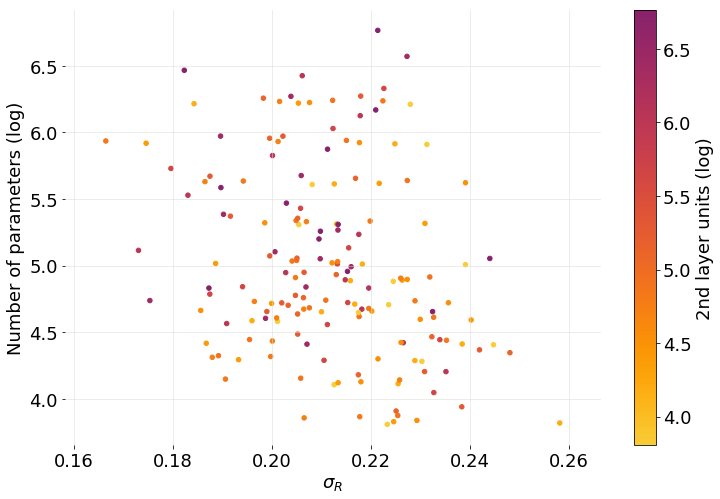

In [179]:
fig = plt.figure(figsize=(12,8))

plt.box(on=None)
plt.grid(color='#dbdbd9', linewidth=0.5)
plt.xlabel('$\sigma_{R}$', fontsize = 18)
plt.ylabel('Number of parameters (log)', fontsize = 18)
ax = fig.add_subplot(111)
ax.scatter(stats_short['untrained_accuracy_std']/stats_short['untrained_accuracy_mean'],
           stats_short['n_parameters'],
           s=20,
           c=np.log10(stats_short['n_units2']),
           cmap=new_cmap,
           vmin=min_units,
           vmax=max_units
           )

clb = fig.colorbar(psm, ax=ax)
clb.set_label('2nd layer units (log)', fontsize = 18)
plt.savefig("{0}/Outputs/Nparam_nUnits2.png".format(os.path.split(path)[0]), bbox_inches='tight', dpi=100)

In [16]:
# Pearson's and Spearman's R coefficients, showing qualitative correlation
# between mean trained accuracy and relative standard deviation on the untrained accuracy.
print(scipystats.pearsonr(stats_short['trained_accuracy_mean'], stats_short['untrained_accuracy_std']/stats_short['untrained_accuracy_mean']))
print(scipystats.spearmanr(stats_short['trained_accuracy_mean'], stats_short['untrained_accuracy_std']/stats_short['untrained_accuracy_mean']))

(-0.3574748559942117, 1.8304351794777112e-06)
SpearmanrResult(correlation=-0.3206727661478793, pvalue=2.1319165591322505e-05)
